# Explorative Analysis of PDB Single Mutation Results

In [2]:
%matplotlib inline

import warnings
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import tempfile
from pathlib import Path
from pandas.api.types import union_categoricals
from io import StringIO

# project root dir
root_dir = Path('/local/sieg/projekte/microminer_evaluation')
sys.path.insert(0, str(root_dir.resolve()))

import helper
from helper.constants import one_2_three_dict, three_2_one_dict, MM_QUERY_NAME, MM_QUERY_CHAIN, MM_QUERY_AA, MM_QUERY_POS, \
                             MM_HIT_NAME, MM_HIT_CHAIN, MM_HIT_AA, MM_HIT_POS
from helper.tmalign import call_tmalign, parse_stdout
from helper.utils import unpack_gz, count_lines
from helper.datasets.utils import get_pdb_file_path
from helper.data_operations import read_microminer_csv

In [2]:
MM_big_result_file = Path('/local/sieg/pdb_all.tsv')


In [4]:
nof_lines = count_lines(MM_big_result_file)
nof_lines

215721051

In [6]:
cols = [MM_QUERY_NAME, MM_QUERY_CHAIN, MM_QUERY_AA, MM_QUERY_POS, MM_HIT_NAME, MM_HIT_CHAIN, MM_HIT_AA, MM_HIT_POS]

def use_col(c):
    return c not in ['querySiteGaps','hitSiteGaps','siteMismatches', 'alignmentScore', 
                     'siteIdentity', 'siteTMScore', 'fullSeqId', 'alignmentLDDT']

col_dtypes = {c:'category' for c in cols}
col_dtypes.update({'siteIdentity': 'float16', 'siteBackBoneRMSD': 'float16', 'siteAllAtomRMSD': 'float16',
                   'siteTMScore': 'float16',
                   'nofSiteResidues': np.uint8, 'alignmentLDDT': 'float16'})
df = pd.read_csv(MM_big_result_file, sep='\t', header=0, dtype=col_dtypes,
                usecols=use_col, skiprows=lambda row_idx: not dup_mask[row_idx])
df

,queryName,queryAA,queryChain,queryPos,hitName,hitAA,hitChain,hitPos,siteBackBoneRMSD,nofSiteResidues
0,2LIZ,ARG,A,188,2HDO,GLU,A,167,2.134766,5
1,2LIZ,GLN,A,189,8DZ6,LYS,A,189,3.916016,7
2,2LIZ,GLN,A,192,8DGB,THR,A,192,4.792969,10
3,2LIZ,GLN,A,192,8DGB,THR,B,192,4.769531,10
4,2LIZ,ALA,A,193,8DZA,THR,B,193,4.976562,9
...,...,...,...,...,...,...,...,...,...,...
78745344,7VXF,VAL,D,1133,8H15,ILE,B,1115,0.429932,16
78745345,7VXF,VAL,D,1133,8H15,ILE,C,1115,0.420898,16
78745346,7VXF,VAL,D,1133,8H16,ILE,A,1115,0.388916,16
78745347,7VXF,VAL,D,1133,8H16,ILE,B,1115,0.437012,16


In [15]:
# drop non-standard amino acid hits
df = df[(df['queryAA'].isin(three_2_one_dict) & df['hitAA'].isin(three_2_one_dict))]

In [23]:
# clean category type for amino acids
df['queryAA'] = df['queryAA'].cat.remove_unused_categories()
df['hitAA'] = df['hitAA'].cat.remove_unused_categories()

# make them comparable across columns
t = union_categoricals([df['queryAA'], df['hitAA']])
df['queryAA'] = df['queryAA'].astype(t.dtype)
df['hitAA'] = df['hitAA'].astype(t.dtype)

In [24]:
df.memory_usage(deep=True, index=True).sum() /1024/1024, 'mb'

(2051.0401401519775, 'mb')

array([[<AxesSubplot:title={'center':'siteBackBoneRMSD'}>]], dtype=object)

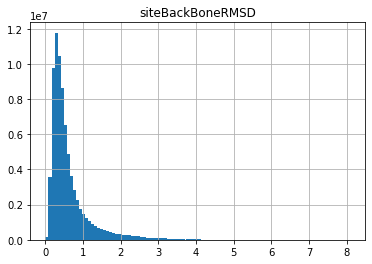

In [26]:
df.hist('siteBackBoneRMSD', bins=100)

In [50]:
r = df.groupby(['queryAA', 'hitAA'])['siteBackBoneRMSD'].median()
r

queryAA  hitAA
ALA      ALA           NaN
         ARG      0.454102
         ASN      0.416016
         ASP      0.424072
         CYS      0.333984
                    ...   
VAL      SER      0.475098
         THR      0.433105
         TRP      0.514648
         TYR      0.530762
         VAL           NaN
Name: siteBackBoneRMSD, Length: 400, dtype: float16

In [51]:
r = r.reset_index()
r

,queryAA,hitAA,siteBackBoneRMSD
0,ALA,ALA,NaN
1,ALA,ARG,0.454102
2,ALA,ASN,0.416016
3,ALA,ASP,0.424072
4,ALA,CYS,0.333984
...,...,...,...
395,VAL,SER,0.475098
396,VAL,THR,0.433105
397,VAL,TRP,0.514648
398,VAL,TYR,0.530762


In [52]:
r_piv = r.pivot(values = 'siteBackBoneRMSD', index=['queryAA'], columns = 'hitAA')#.reset_index()
r_piv

hitAA,ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,HIS,ILE,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL
queryAA,,,,,,,,,,,,,,,,,,,,
ALA,NaN,0.454102,0.416016,0.424072,0.333984,0.406006,0.435059,0.408936,0.381104,0.521973,0.329102,0.371094,0.420898,0.408936,0.469971,0.427002,0.431885,0.469971,0.422119,0.410889
ARG,0.486084,NaN,0.325928,0.724609,0.347900,0.379883,0.333008,0.437012,0.319092,0.687012,0.649902,0.400879,0.469971,0.325928,0.410889,0.343994,0.422119,0.467041,0.676270,0.370117
ASN,0.430908,0.426025,NaN,0.334961,0.297119,0.504883,0.482910,0.471924,0.382080,0.626953,0.582031,0.688965,0.441895,0.748047,0.667969,0.409912,0.408936,0.383057,0.620117,0.287109
ASP,0.452881,0.482910,0.333984,NaN,0.545898,0.398926,0.334961,0.776855,0.479004,1.326172,0.530762,0.394043,0.837891,1.057617,1.009766,0.341064,0.378906,0.182007,0.708984,0.458984
CYS,0.301025,0.386963,0.302979,0.472900,NaN,0.383057,0.350098,0.454102,0.372559,0.648926,0.252930,0.309082,0.609863,0.350098,0.530762,0.458984,0.310059,0.616211,0.322998,0.320068
GLN,0.409912,0.366943,0.454102,0.446045,0.503906,NaN,0.451904,0.581055,0.408936,0.717285,0.500977,0.375977,0.543945,0.793945,0.533203,0.329102,0.488037,0.799316,0.399414,0.478027
GLU,0.441895,0.403076,0.528809,0.382080,0.416992,0.454102,NaN,0.459961,0.406982,0.702148,0.555176,0.399902,0.365967,0.956055,0.430908,0.456055,0.487061,0.405029,0.482910,0.400879
GLY,0.454102,0.368896,0.554199,0.673828,0.761230,0.577148,0.458984,NaN,0.746094,1.160156,2.353516,0.426025,0.574219,0.923828,0.791992,0.491943,0.379883,0.583008,1.144531,0.759766
HIS,0.360107,0.366943,0.415039,0.423096,0.341064,0.351074,0.292969,0.625000,NaN,0.819824,0.324951,0.472900,0.589844,0.301025,0.419922,0.506836,0.405029,0.358398,0.398926,0.725098


<AxesSubplot:xlabel='hitAA', ylabel='queryAA'>

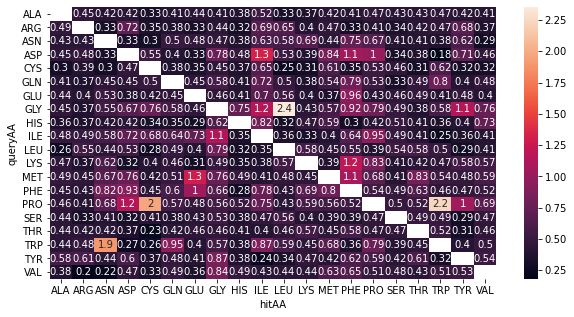

In [53]:
plt.rcParams['figure.figsize'] = [10, 5]
sns.heatmap(data=r_piv, annot=True)

In [33]:
#  Matrix made by matblas from blosum62.iij
#  * column uses minimum score
#  BLOSUM Clustered Scoring Matrix in 1/2 Bit Units
#  Blocks Database = /data/blocks_5.0/blocks.dat
#  Cluster Percentage: >= 62
#  Entropy =   0.6979, Expected =  -0.5209
alphabet = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I' 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
blosum62 = np.loadtxt(StringIO("""
4 -1 -2 -2  0 -1 -1  0 -2 -1 -1 -1 -1 -2 -1  1  0 -3 -2  0
-1  5  0 -2 -3  1  0 -2  0 -3 -2  2 -1 -3 -2 -1 -1 -3 -2 -3
-2  0  6  1 -3  0  0  0  1 -3 -3  0 -2 -3 -2  1  0 -4 -2 -3
-2 -2  1  6 -3  0  2 -1 -1 -3 -4 -1 -3 -3 -1  0 -1 -4 -3 -3
0 -3 -3 -3  9 -3 -4 -3 -3 -1 -1 -3 -1 -2 -3 -1 -1 -2 -2 -1
-1  1  0  0 -3  5  2 -2  0 -3 -2  1  0 -3 -1  0 -1 -2 -1 -2
-1  0  0  2 -4  2  5 -2  0 -3 -3  1 -2 -3 -1  0 -1 -3 -2 -2
0 -2  0 -1 -3 -2 -2  6 -2 -4 -4 -2 -3 -3 -2  0 -2 -2 -3 -3
-2  0  1 -1 -3  0  0 -2  8 -3 -3 -1 -2 -1 -2 -1 -2 -2  2 -3
-1 -3 -3 -3 -1 -3 -3 -4 -3  4  2 -3  1  0 -3 -2 -1 -3 -1  3
-1 -2 -3 -4 -1 -2 -3 -4 -3  2  4 -2  2  0 -3 -2 -1 -2 -1  1
-1  2  0 -1 -3  1  1 -2 -1 -3 -2  5 -1 -3 -1  0 -1 -3 -2 -2
-1 -1 -2 -3 -1  0 -2 -3 -2  1  2 -1  5  0 -2 -1 -1 -1 -1  1
-2 -3 -3 -3 -2 -3 -3 -3 -1  0  0 -3  0  6 -4 -2 -2  1  3 -1
-1 -2 -2 -1 -3 -1 -1 -2 -2 -3 -3 -1 -2 -4  7 -1 -1 -4 -3 -2
1 -1  1  0 -1  0  0  0 -1 -2 -2  0 -1 -2 -1  4  1 -3 -2 -2
0 -1  0 -1 -1 -1 -1 -2 -2 -1 -1 -1 -1 -2 -1  1  5 -2 -2  0
-3 -3 -4 -4 -2 -2 -3 -2 -2 -3 -2 -3 -1  1 -4 -3 -2 11  2 -3
-2 -2 -2 -3 -2 -1 -2 -3  2 -1 -1 -2 -1  3 -3 -2 -2  2  7 -1
0 -3 -3 -3 -1 -2 -2 -3 -3  3  1 -2  1 -1 -2 -2  0 -3 -1  4
"""))

# For mutation analysis we do not need the diagonal 
# and non-nan values confuse the plotting library
np.fill_diagonal(blosum62, np.nan)

blosum62.flatten().shape

(400,)

In [34]:
r_piv.values.ravel()
blosum62.ravel()

array([nan, -1., -2., -2.,  0., -1., -1.,  0., -2., -1., -1., -1., -1.,
       -2., -1.,  1.,  0., -3., -2.,  0., -1., nan,  0., -2., -3.,  1.,
        0., -2.,  0., -3., -2.,  2., -1., -3., -2., -1., -1., -3., -2.,
       -3., -2.,  0., nan,  1., -3.,  0.,  0.,  0.,  1., -3., -3.,  0.,
       -2., -3., -2.,  1.,  0., -4., -2., -3., -2., -2.,  1., nan, -3.,
        0.,  2., -1., -1., -3., -4., -1., -3., -3., -1.,  0., -1., -4.,
       -3., -3.,  0., -3., -3., -3., nan, -3., -4., -3., -3., -1., -1.,
       -3., -1., -2., -3., -1., -1., -2., -2., -1., -1.,  1.,  0.,  0.,
       -3., nan,  2., -2.,  0., -3., -2.,  1.,  0., -3., -1.,  0., -1.,
       -2., -1., -2., -1.,  0.,  0.,  2., -4.,  2., nan, -2.,  0., -3.,
       -3.,  1., -2., -3., -1.,  0., -1., -3., -2., -2.,  0., -2.,  0.,
       -1., -3., -2., -2., nan, -2., -4., -4., -2., -3., -3., -2.,  0.,
       -2., -2., -3., -3., -2.,  0.,  1., -1., -3.,  0.,  0., -2., nan,
       -3., -3., -1., -2., -1., -2., -1., -2., -2.,  2., -3., -1

<AxesSubplot:xlabel='blosum62', ylabel='localCalphaRMSD'>

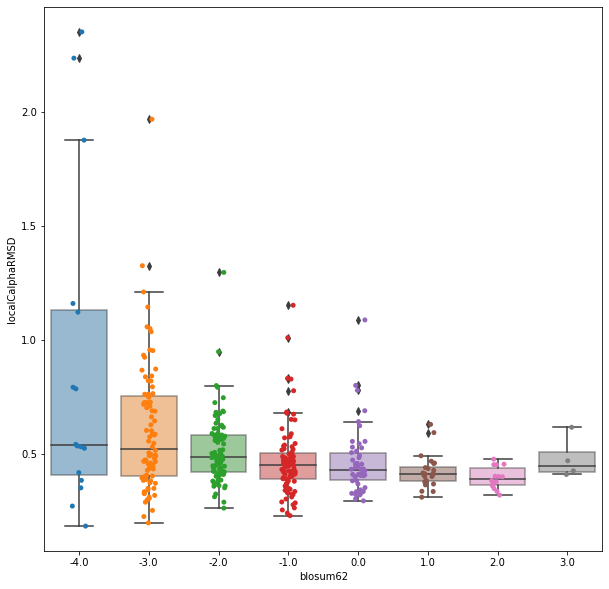

In [56]:
df_lin = pd.DataFrame({'blosum62': blosum62.ravel(), 'localCalphaRMSD': r_piv.values.ravel()})
sns.boxplot(data=df_lin, x='blosum62', y='localCalphaRMSD', boxprops={'alpha': 0.5})
sns.stripplot(data=df_lin, x='blosum62', y='localCalphaRMSD', dodge=True)

In [36]:
df_lin.max()

blosum62           3.000000
localCalphaRMSD    1.850586
dtype: float64

In [46]:
df_counts = df.groupby(['queryAA', 'hitAA']).size().reset_index()
df_counts_piv = df_counts.pivot(values=0, index=['queryAA'], columns = 'hitAA')#.reset_index()
df_counts

,queryAA,hitAA,0
0,ALA,ALA,0
1,ALA,ARG,128684
2,ALA,ASN,198175
3,ALA,ASP,371726
4,ALA,CYS,778558
...,...,...,...
395,VAL,SER,48898
396,VAL,THR,258564
397,VAL,TRP,5280
398,VAL,TYR,20641


<AxesSubplot:xlabel='hitAA', ylabel='queryAA'>

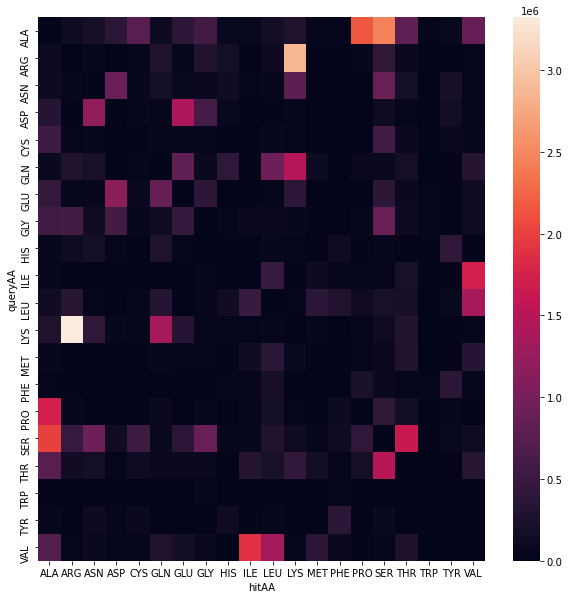

In [55]:
# plt.rcParams['figure.figsize'] = [10, 10]
sns.heatmap(data=df_counts_piv, annot=False)